# Function Optimization with Genetic Algorithm

This notebook demonstrates how to solve function optimization problems using the genetic algorithm implemented in `src/lib/ga.py`. We'll optimize several well-known test functions like Ackley, Rastrigin, and Rosenbrock.

In [1]:
# Add path to the central init_notebook.py file (just 5 lines!)
import sys
from pathlib import Path

doc_dir = Path().absolute().parent  # This points to the doc/ directory
if str(doc_dir) not in sys.path:
    sys.path.insert(0, str(doc_dir))

# Now import everything with one line
from notebook import GeneticAlgorithm, AssetType, am, torch, np, plt

from dataclasses import dataclass
from typing import List, Tuple, Callable

Added c:\Users\fire\Lab\ai to Python path
[INFO] No seed provided, using default seed 42. To set a new seed, call set_seeds(seed=YOUR_SEED)


In [2]:
@dataclass
class FunctionOptimizationData:
    """Clase para almacenar los datos del problema de optimización de funciones"""

    function: Callable  # La función a optimizar
    function_name: str  # Nombre de la función
    dimensions: int  # Número de dimensiones
    bounds: Tuple[float, float]  # Límites inferior y superior para cada dimensión
    is_minimization: (
        bool  # Si es un problema de minimización (True) o maximización (False)
    )
    optimal_value: float = None  # Valor óptimo conocido de la función (si existe)
    optimal_solution: List[float] = None  # Solución óptima conocida (si existe)

In [3]:
def rastrigin_function(x: torch.Tensor) -> torch.Tensor:
    """
    Función de Rastrigin: f(x) = 10n + sum(x_i^2 - 10cos(2πx_i))
    Mínimo global en x = [0, 0, ..., 0] con f(x) = 0

    Args:
        x: Tensor de tamaño [population_size, dimensions]

    Returns:
        Valores de la función para cada individuo [population_size]
    """
    n = x.shape[1]
    return 10 * n + torch.sum(x**2 - 10 * torch.cos(2 * np.pi * x), dim=1)


def ackley_function(x: torch.Tensor) -> torch.Tensor:
    """
    Función de Ackley: f(x) = -20exp(-0.2sqrt(0.5*sum(x_i^2))) - exp(0.5*sum(cos(2πx_i))) + 20 + e
    Mínimo global en x = [0, 0, ..., 0] con f(x) = 0

    Args:
        x: Tensor de tamaño [population_size, dimensions]

    Returns:
        Valores de la función para cada individuo [population_size]
    """
    a = 20
    b = 0.2
    c = 2 * np.pi

    term1 = -a * torch.exp(-b * torch.sqrt(torch.mean(x**2, dim=1)))
    term2 = -torch.exp(torch.mean(torch.cos(c * x), dim=1))

    return term1 + term2 + a + np.e


def rosenbrock_function(x: torch.Tensor) -> torch.Tensor:
    """
    Función de Rosenbrock (banana function): f(x) = sum(100*(x_{i+1} - x_i^2)^2 + (1 - x_i)^2)
    Mínimo global en x = [1, 1, ..., 1] con f(x) = 0

    Args:
        x: Tensor de tamaño [population_size, dimensions]

    Returns:
        Valores de la función para cada individuo [population_size]
    """
    pop_size, dims = x.shape
    result = torch.zeros(pop_size)

    for i in range(dims - 1):
        result += 100 * (x[:, i + 1] - x[:, i] ** 2) ** 2 + (1 - x[:, i]) ** 2

    return result

In [4]:
def function_optimization_fitness(
    population: torch.Tensor, problem_data: FunctionOptimizationData
) -> torch.Tensor:
    """
    Función de fitness para el problema de optimización de funciones

    Args:
        population: Tensor de población [pop_size, chromosome_length]
        problem_data: Datos del problema

    Returns:
        Tensor con los valores de fitness de cada individuo
    """
    # Decodificar los cromosomas a valores en el dominio de la función
    lower_bound, upper_bound = problem_data.bounds
    decoded_chromosomes = population * (upper_bound - lower_bound) + lower_bound

    # Calcular los valores de la función para cada individuo
    function_values = problem_data.function(decoded_chromosomes)

    # Si es un problema de minimización, convertimos a fitness
    if problem_data.is_minimization:
        # Para minimización, cuanto menor sea el valor de la función, mayor será el fitness
        # Usamos un valor máximo para asegurar que todos los fitness son positivos
        max_value = torch.max(function_values) + 1
        fitness = max_value - function_values
    else:
        # Para maximización, el fitness es directamente el valor de la función
        fitness = function_values

    return fitness


def decode_solution(
    chromosome: torch.Tensor, problem_data: FunctionOptimizationData
) -> torch.Tensor:
    """
    Decodifica un cromosoma en una solución para el problema de optimización

    Args:
        chromosome: Tensor del cromosoma [chromosome_length]
        problem_data: Datos del problema

    Returns:
        Solución decodificada
    """
    lower_bound, upper_bound = problem_data.bounds
    return chromosome * (upper_bound - lower_bound) + lower_bound

In [5]:
def display_solution(chromosome: torch.Tensor, problem_data: FunctionOptimizationData):
    """
    Muestra la solución encontrada para el problema de optimización de funciones

    Args:
        chromosome: Cromosoma (solución) encontrado
        problem_data: Datos del problema
    """
    solution = decode_solution(chromosome, problem_data)
    solution_list = solution.tolist()

    # Calcular el valor de la función para la solución
    function_value = problem_data.function(solution.unsqueeze(0)).item()

    print(
        f"\nResultados de la optimización de la función {problem_data.function_name}:"
    )
    print(f"{'Mejor solución encontrada:':<30} {solution_list}")
    print(f"{'Valor de la función:':<30} {function_value}")

    if problem_data.optimal_value is not None:
        error = abs(function_value - problem_data.optimal_value)
        print(f"{'Valor óptimo conocido:':<30} {problem_data.optimal_value}")
        print(f"{'Error absoluto:':<30} {error}")

    if problem_data.optimal_solution is not None:
        distance = torch.norm(
            solution - torch.tensor(problem_data.optimal_solution)
        ).item()
        print(f"{'Solución óptima conocida:':<30} {problem_data.optimal_solution}")
        print(f"{'Distancia a la solución óptima:':<30} {distance}")

In [6]:
def plot_function_2d(function, bounds, resolution=100, title="Function Plot"):
    """
    Genera un gráfico 3D de una función de 2 variables

    Args:
        function: La función a graficar
        bounds: Límites [min, max] para ambas dimensiones
        resolution: Resolución del gráfico
        title: Título del gráfico
    """
    lower_bound, upper_bound = bounds
    x = np.linspace(lower_bound, upper_bound, resolution)
    y = np.linspace(lower_bound, upper_bound, resolution)
    X, Y = np.meshgrid(x, y)

    # Crear tensor para evaluar la función
    points = torch.tensor(
        np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32
    )
    Z = function(points).reshape(resolution, resolution).numpy()

    # Crear gráfico 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.8)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("f(X, Y)")
    ax.set_title(title)

    # Añadir barra de color
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.show()
    return fig, ax  # Return for later use

In [7]:
def plot_function_with_solution(
    function, bounds, solution, optimal_solution, optimal_value, title
):
    """
    Genera un gráfico 3D de una función con la solución encontrada y la óptima marcadas

    Args:
        function: La función a graficar
        bounds: Límites [min, max] para ambas dimensiones
        solution: Solución encontrada [x, y]
        optimal_solution: Solución óptima conocida [x, y]
        optimal_value: Valor óptimo conocido
        title: Título del gráfico
    """
    lower_bound, upper_bound = bounds
    x = np.linspace(lower_bound, upper_bound, 100)
    y = np.linspace(lower_bound, upper_bound, 100)
    X, Y = np.meshgrid(x, y)

    points = torch.tensor(
        np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32
    )
    Z = function(points).reshape(100, 100).numpy()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.6)

    # Marcar la solución encontrada
    ax.scatter(
        solution[0],
        solution[1],
        function(torch.tensor([solution])).item(),
        color="red",
        s=100,
        label="Solución encontrada",
    )

    # Marcar la solución óptima
    ax.scatter(
        optimal_solution[0],
        optimal_solution[1],
        optimal_value,
        color="green",
        s=100,
        label="Solución óptima",
    )

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("f(X, Y)")
    ax.set_title(title)
    ax.legend()

    plt.show()
    return fig, ax  # Return for later use

## Solve the Function Optimization Problem

In [8]:
print("\033[92mFunction Optimization Problem\033[0m\n")
print("1. Rastrigin Function (más difícil)")
print("2. Ackley Function (dificultad media)")
print("3. Rosenbrock Function (dificultad media-alta)")

# Select which function to optimize
function_choice = 2  # Change this to try different functions

# Configure the problem based on the selected function
if function_choice == 1:
    function = rastrigin_function
    function_name = "Rastrigin"
    bounds = (-5.12, 5.12)
    optimal_solution = [0.0, 0.0]
    optimal_value = 0.0
elif function_choice == 2:
    function = ackley_function
    function_name = "Ackley"
    bounds = (-5, 5)
    optimal_solution = [0.0, 0.0]
    optimal_value = 0.0
else:
    function = rosenbrock_function
    function_name = "Rosenbrock"
    bounds = (-2, 2)
    optimal_solution = [1.0, 1.0]
    optimal_value = 0.0

dimensions = 2  # Using 2 dimensions for visualization

print(f"\nOptimizando la función {function_name} en {dimensions} dimensiones.")
print(f"Rango de búsqueda: [{bounds[0]}, {bounds[1]}] para cada dimensión.")
print(f"Solución óptima conocida: {optimal_solution} con valor {optimal_value}.")

Function Optimization Problem

1. Rastrigin Function (más difícil)
2. Ackley Function (dificultad media)
3. Rosenbrock Function (dificultad media-alta)

Optimizando la función Ackley en 2 dimensiones.
Rango de búsqueda: [-5, 5] para cada dimensión.
Solución óptima conocida: [0.0, 0.0] con valor 0.0.


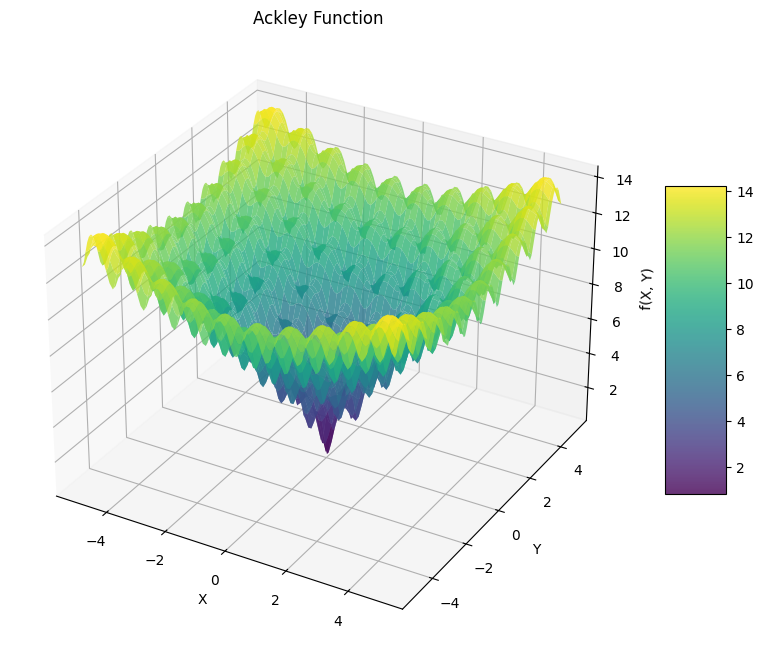

(<Figure size 1000x800 with 2 Axes>,
 <Axes3D: title={'center': 'Ackley Function'}, xlabel='X', ylabel='Y', zlabel='f(X, Y)'>)

In [9]:
# Create data object for the problem
problem_data = FunctionOptimizationData(
    function=function,
    function_name=function_name,
    dimensions=dimensions,
    bounds=bounds,
    is_minimization=True,
    optimal_value=optimal_value,
    optimal_solution=optimal_solution,
)

# Visualize the function
plot_function_2d(function, bounds, title=f"{function_name} Function")

In [10]:
# Genetic Algorithm parameters
population_size = 100
n_generations = 150

# Create and run the genetic algorithm
ga = GeneticAlgorithm(
    pop_size=population_size,
    chromosome_length=dimensions,
    fitness_function=function_optimization_fitness,
    problem_data=problem_data,
    mutation_rate=0.1,
    crossover_rate=0.8,
    elitism=5,
    maximize=True,  # Always True because we convert minimization problem
    binary=False,  # Using continuous representation for this problem
)

# Run the genetic algorithm
best_chromosome, best_fitness = ga.run(n_generations)

Generación 1: Mejor fitness = 12.56, Fitness promedio = 5.15
Generación 10: Mejor fitness = 12.56, Fitness promedio = 8.22
Generación 20: Mejor fitness = 12.56, Fitness promedio = 7.64
Generación 30: Mejor fitness = 12.56, Fitness promedio = 5.88
Generación 40: Mejor fitness = 12.56, Fitness promedio = 7.87
Generación 50: Mejor fitness = 12.56, Fitness promedio = 8.34
Generación 60: Mejor fitness = 12.56, Fitness promedio = 8.02
Generación 70: Mejor fitness = 12.56, Fitness promedio = 5.72
Generación 80: Mejor fitness = 12.56, Fitness promedio = 7.94
Generación 90: Mejor fitness = 12.56, Fitness promedio = 8.10
Generación 100: Mejor fitness = 12.56, Fitness promedio = 7.69
Generación 110: Mejor fitness = 12.56, Fitness promedio = 8.79
Generación 120: Mejor fitness = 12.56, Fitness promedio = 7.96
Generación 130: Mejor fitness = 12.56, Fitness promedio = 7.32
Generación 140: Mejor fitness = 12.56, Fitness promedio = 7.74
Generación 150: Mejor fitness = 12.56, Fitness promedio = 7.52

Me

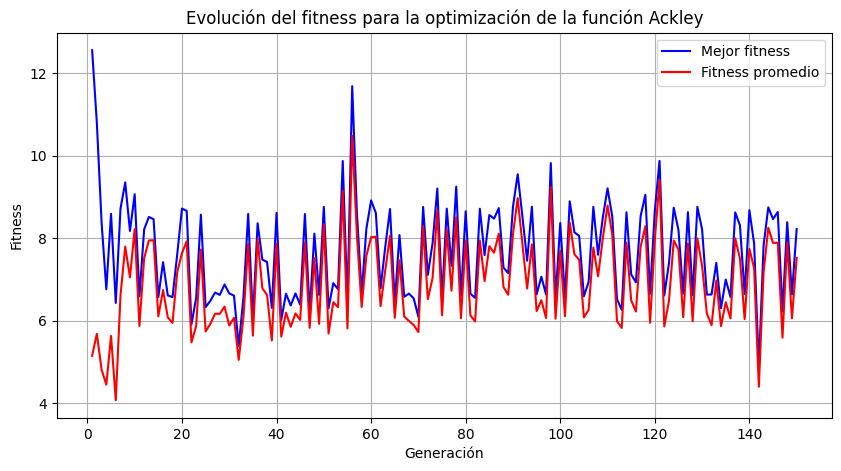

In [11]:
# Visualize fitness evolution
ga.plot_history(
    title=f"Evolución del fitness para la optimización de la función {function_name}"
)

In [12]:
# Display solution details
display_solution(ga.best_chromosome, problem_data)


Resultados de la optimización de la función Ackley:
Mejor solución encontrada:     [0.07296133041381836, -0.2985410690307617]
Valor de la función:           2.221442222595215
Valor óptimo conocido:         0.0
Error absoluto:                2.221442222595215
Solución óptima conocida:      [0.0, 0.0]
Distancia a la solución óptima: 0.30732738971710205


C:\Users\fire\AppData\Local\Temp\ipykernel_23284\1221743714.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  function(torch.tensor([solution])).item(),


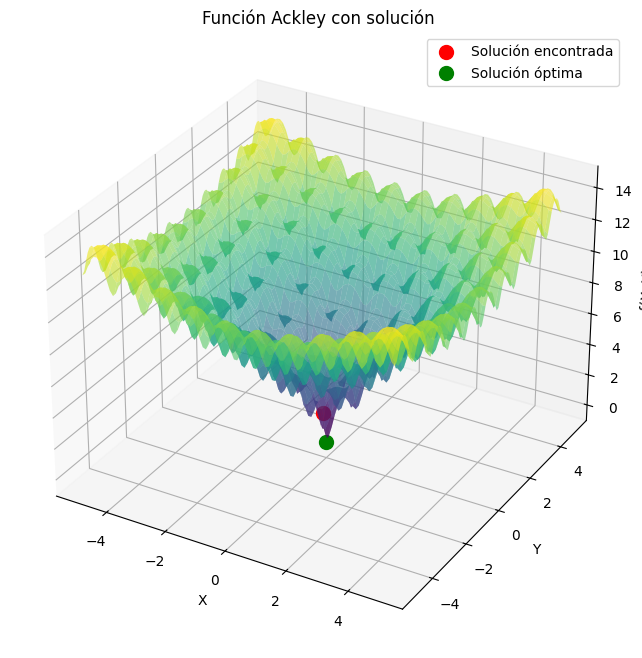

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'Función Ackley con solución'}, xlabel='X', ylabel='Y', zlabel='f(X, Y)'>)

In [13]:
# Visualize the function with the solution
solution = decode_solution(ga.best_chromosome, problem_data).numpy()

plot_function_with_solution(
    function,
    bounds,
    solution,
    optimal_solution,
    optimal_value,
    f"Función {function_name} con solución",
)

## Save Results to Temp Directory

In [14]:
# Ensure temp directory exists
temp_dir = am.get_asset_path(AssetType.TEMP)
am.ensure_path_exists(temp_dir)

# Create and save the fitness evolution figure
plt.figure(figsize=(10, 5))
generations = range(1, len(ga.best_fitness_history) + 1)
plt.plot(generations, ga.best_fitness_history, "b-", label="Mejor fitness")
plt.plot(generations, ga.avg_fitness_history, "r-", label="Fitness promedio")
plt.title(f"Evolución del fitness para {function_name} (guardado)")
plt.xlabel("Generación")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)

# Get path for saving and save
fitness_path = am.get_temp(
    f"{function_name.lower()}_fitness_history.png", absolute=True
)
plt.savefig(fitness_path)
plt.close()

print(f"Saved fitness history to: {fitness_path}")

Saved fitness history to: c:\Users\fire\Lab\ai\data\temp\ackley_fitness_history.png


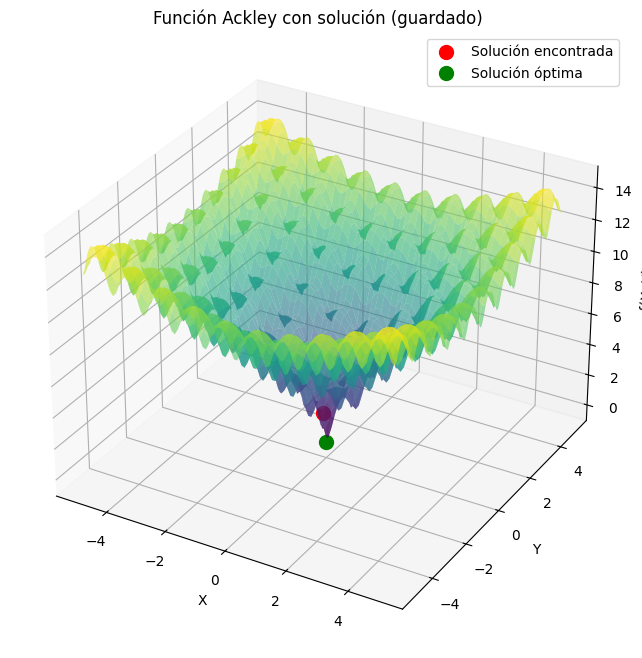

Saved solution visualization to: c:\Users\fire\Lab\ai\data\temp\ackley_solution.png


In [15]:
# Save the solution visualization
fig, ax = plot_function_with_solution(
    function,
    bounds,
    solution,
    optimal_solution,
    optimal_value,
    f"Función {function_name} con solución (guardado)",
)

# Get path for saving and save
solution_path = am.get_temp(f"{function_name.lower()}_solution.png", absolute=True)
fig.savefig(solution_path)
plt.close(fig)

print(f"Saved solution visualization to: {solution_path}")